In [139]:
## Make width of notebook 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
datasets_dir = 'datasets/'

## If running in google colab:
# from google.colab import drive
# drive.mount('/content/drive') # Needed to access drive files
# datasets_dir = 'drive/Shareddrives/CMPE-255-Term-Project/Dataset/'

In [141]:
def init_datasets():
    games_df = pd.read_csv(datasets_dir+'games.csv')
    winners_df = games_df['HOME_TEAM_WINS']
    del games_df['HOME_TEAM_WINS']
    games_details_df = pd.read_csv(datasets_dir+'games_details.csv')
    teams_df = pd.read_csv(datasets_dir+'teams.csv')
    players_df = pd.read_csv(datasets_dir+'players.csv')
    ranking_df = pd.read_csv(datasets_dir+'ranking.csv')
    # Clean up unnecessary columns
    del games_df['GAME_STATUS_TEXT'] # Always 'Final'
    del ranking_df['LEAGUE_ID'] # Always 0
    del teams_df['LEAGUE_ID'] # Always 0
    del teams_df['YEARFOUNDED'] # Redundant w/ 'MIN_YEAR'
    del teams_df['ARENA'] # Name of arena not needed
    del teams_df['DLEAGUEAFFILIATION'] # Name of arena not needed

    return games_df, winners_df, games_details_df, teams_df, players_df, ranking_df

In [142]:
games_df, winners_df, games_details_df, teams_df, players_df, ranking_df = init_datasets()

# The Datasets

## Issue w/ dataset

The dataset is currently lacking data that can be used for prediction since most of the data is after the fact. Specifically, we are trying to predict winners of a game but the current data shows only the stats of the game after it has completed, so this data can't be used to predict winners.

### Solution:

We need to scrape more data from stats.nba.com and/or create a new dataset from the existing datasets, to create data that can be used to build a model for predicting winners, i.e. stats of a team/player on the day of a game.
- Add columns for team stats to the rankings.csv dataset
- Create a new dataset for player stats on the day of a game (before the game starts)

In [143]:
winners_df # Whether the home team won in a game in each row of `games_df`

0        1
1        1
2        0
3        0
4        0
        ..
23515    1
23516    0
23517    1
23518    1
23519    0
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [164]:
games_df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,2020-12-19,12000047,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,0.425,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0
1,2020-12-19,12000048,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,0.295,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0
2,2020-12-19,12000049,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,0.396,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0
3,2020-12-18,12000039,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,0.262,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0
4,2020-12-18,12000040,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,0.356,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,2014-10-06,11400007,1610612737,1610612740,2014,1610612737,93.0,0.419,0.821,0.421,24.0,50.0,1610612740,87.0,0.366,0.643,0.375,17.0,43.0
23516,2014-10-06,11400004,1610612741,1610612764,2014,1610612741,81.0,0.338,0.719,0.381,18.0,40.0,1610612764,85.0,0.411,0.636,0.267,17.0,47.0
23517,2014-10-06,11400005,1610612747,1610612743,2014,1610612747,98.0,0.448,0.682,0.500,29.0,45.0,1610612743,95.0,0.387,0.659,0.500,19.0,43.0
23518,2014-10-05,11400002,1610612761,1610612758,2014,1610612761,99.0,0.440,0.771,0.333,21.0,30.0,1610612758,94.0,0.469,0.725,0.385,18.0,45.0


In [145]:
games_details_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,12000047,1610612766,CHA,Charlotte,1628998,Cody Martin,F,NaN,17:06,0.0,...,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,12000047,1610612766,CHA,Charlotte,1629023,P.J. Washington,F,NaN,24:58,4.0,...,1.0,6.0,7.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0
2,12000047,1610612766,CHA,Charlotte,203469,Cody Zeller,C,NaN,22:45,5.0,...,2.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,13.0,-23.0
3,12000047,1610612766,CHA,Charlotte,1628984,Devonte' Graham,G,NaN,31:30,8.0,...,1.0,3.0,4.0,3.0,2.0,0.0,4.0,0.0,25.0,-7.0
4,12000047,1610612766,CHA,Charlotte,1626179,Terry Rozier,G,NaN,26:48,8.0,...,1.0,4.0,5.0,6.0,1.0,0.0,0.0,2.0,24.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585789,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,19,4.0,...,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
585790,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,23,7.0,...,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
585791,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,15,3.0,...,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
585792,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,19,1.0,...,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


In [163]:
ranking_df
# TODO: add columns for Team Stats (PPG, FGP, etc) from stats.nba.com
# RETURNTOPLAY is the period of games after restart due to covid lockdowns in the 19-20 season. https://www.nba.com/stats/returntoplay2020/

,TEAM_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612747,12020,2020-12-21,West,L.A. Lakers,4,4,0,1.000,2-0,2-0,NaN
1,1610612762,12020,2020-12-21,West,Utah,3,3,0,1.000,2-0,1-0,NaN
2,1610612740,12020,2020-12-21,West,New Orleans,2,2,0,1.000,1-0,1-0,NaN
3,1610612745,12020,2020-12-21,West,Houston,4,3,1,0.750,2-0,1-1,NaN
4,1610612763,12020,2020-12-21,West,Memphis,4,3,1,0.750,1-1,2-0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
188378,1610612765,22013,2014-09-01,East,Detroit,82,29,53,0.354,17-24,12-29,NaN
188379,1610612738,22013,2014-09-01,East,Boston,82,25,57,0.305,16-25,9-32,NaN
188380,1610612753,22013,2014-09-01,East,Orlando,82,23,59,0.280,19-22,4-37,NaN
188381,1610612755,22013,2014-09-01,East,Philadelphia,82,19,63,0.232,10-31,9-32,NaN


In [146]:
teams_df

,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,CITY,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH
0,1610612737,1949,2019,ATL,Hawks,Atlanta,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce
1,1610612738,1946,2019,BOS,Celtics,Boston,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens
2,1610612740,2002,2019,NOP,Pelicans,New Orleans,NaN,Tom Benson,Trajan Langdon,Alvin Gentry
3,1610612741,1966,2019,CHI,Bulls,Chicago,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen
4,1610612742,1980,2019,DAL,Mavericks,Dallas,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle
5,1610612743,1976,2019,DEN,Nuggets,Denver,19099.0,Stan Kroenke,Tim Connelly,Michael Malone
6,1610612745,1967,2019,HOU,Rockets,Houston,18104.0,Tilman Fertitta,Daryl Morey,Mike D'Antoni
7,1610612746,1970,2019,LAC,Clippers,Los Angeles,19060.0,Steve Ballmer,Michael Winger,Doc Rivers
8,1610612747,1948,2019,LAL,Lakers,Los Angeles,19060.0,Jerry Buss Family Trust,Rob Pelinka,Frank Vogel
9,1610612748,1988,2019,MIA,Heat,Miami,19600.0,Micky Arison,Pat Riley,Erik Spoelstra


In [148]:
players_df

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019
1,Bojan Bogdanovic,1610612762,202711,2019
2,Rudy Gobert,1610612762,203497,2019
3,Donovan Mitchell,1610612762,1628378,2019
4,Mike Conley,1610612762,201144,2019
...,...,...,...,...
7223,Lanny Smith,1610612758,201831,2009
7224,Warren Carter,1610612752,201999,2009
7225,Bennet Davis,1610612751,201834,2009
7226,Brian Hamilton,1610612751,201646,2009


# Exploring the Data

In [149]:
# Create df with only data
games_data_df = games_df.copy()
for k in ['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','TEAM_ID_home','TEAM_ID_away']:
    del games_data_df[k]
games_data_df['HOME_TEAM_WINS'] = winners_df.copy()
# Create a standard scaled df
standardized_games_data_df = pd.DataFrame(StandardScaler().fit_transform(games_data_df), columns=games_data_df.columns)

## Covariance Matrices

In [150]:
standardized_games_data_df.cov().style.background_gradient(cmap='rainbow',axis=None)

,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
PTS_home,1.000043,0.663135,0.178355,0.420456,0.592882,0.154454,0.476275,0.126362,0.065323,0.057862,0.189984,-0.144456,0.404500
FG_PCT_home,0.663135,1.000043,0.015261,0.442584,0.548555,-0.195913,0.114602,0.041701,0.031580,0.017017,0.008770,-0.462333,0.430439
FT_PCT_home,0.178355,0.015261,1.000043,0.025753,0.012856,-0.056009,0.071703,0.047189,0.035894,0.021346,0.026384,-0.115631,0.090722
FG3_PCT_home,0.420456,0.442584,0.025753,1.000043,0.347660,-0.090760,0.047846,0.009854,0.017592,0.000884,-0.003086,-0.195664,0.296116
AST_home,0.592882,0.548555,0.012856,0.347660,1.000043,0.059332,0.168781,0.002765,0.023217,-0.009111,0.130340,-0.112136,0.307879
REB_home,0.154454,-0.195913,-0.056009,-0.090760,0.059332,1.000043,-0.158422,-0.473228,-0.119572,-0.200249,-0.103779,0.069033,0.242759
PTS_away,0.476275,0.114602,0.071703,0.047846,0.168781,-0.158422,1.000043,0.668372,0.194470,0.405966,0.574492,0.167038,-0.415640
FG_PCT_away,0.126362,0.041701,0.047189,0.009854,0.002765,-0.473228,0.668372,1.000043,0.033878,0.426407,0.519401,-0.179498,-0.433612
FT_PCT_away,0.065323,0.031580,0.035894,0.017592,0.023217,-0.119572,0.194470,0.033878,1.000043,0.028495,0.018167,-0.044822,-0.101481
FG3_PCT_away,0.057862,0.017017,0.021346,0.000884,-0.009111,-0.200249,0.405966,0.426407,0.028495,1.000043,0.316334,-0.098034,-0.284728


## Scatter Matrices

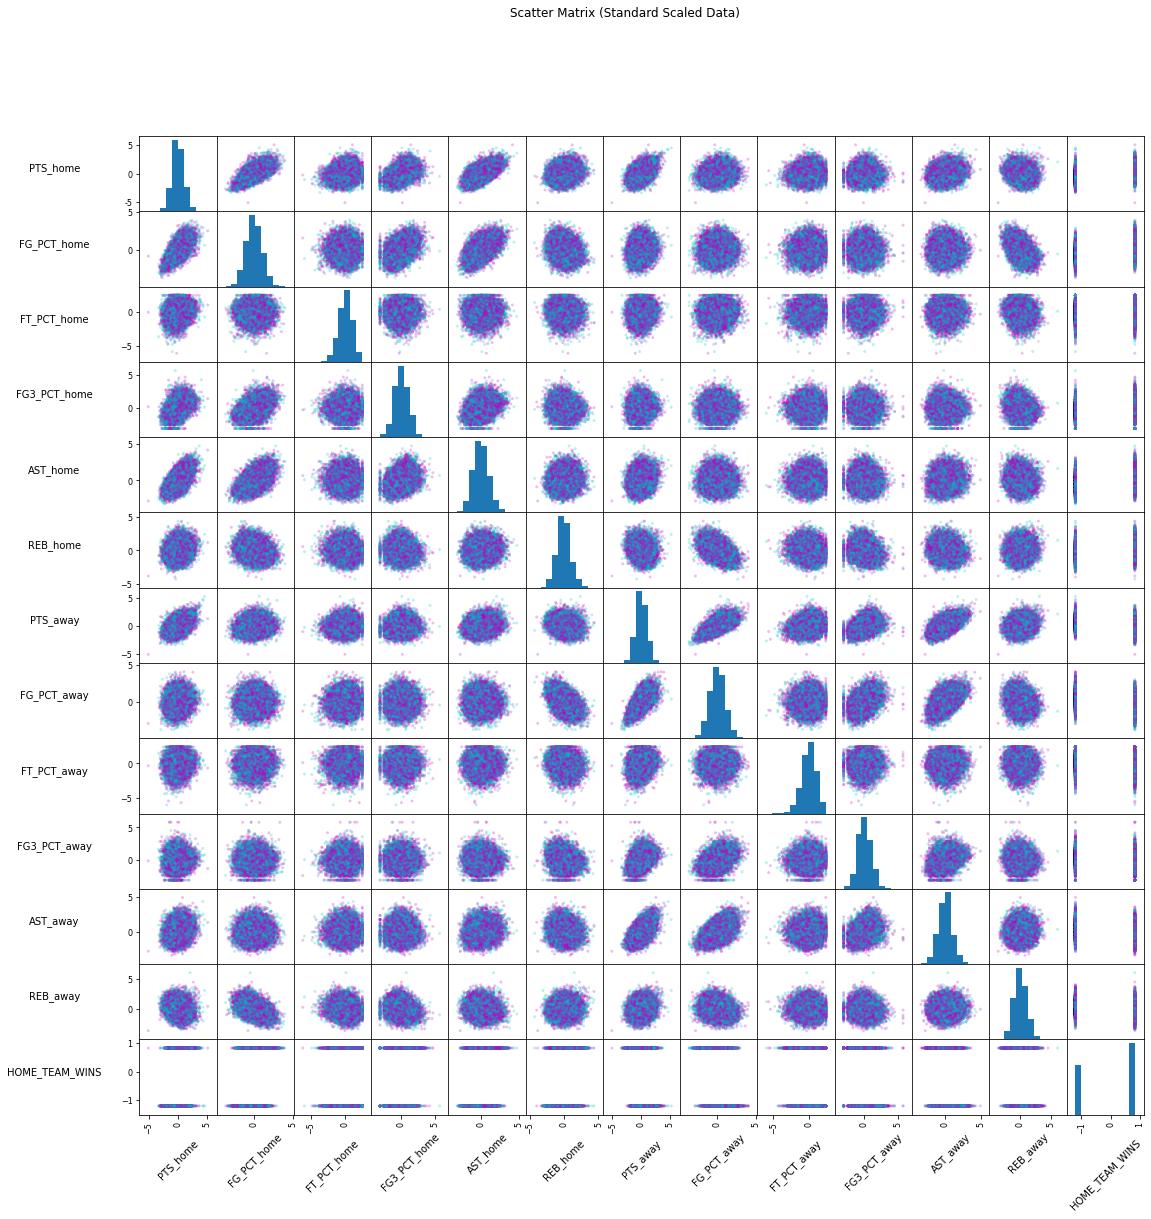

In [151]:
sm=pd.plotting.scatter_matrix(
    standardized_games_data_df,
    alpha=0.25,
    figsize=(18,18),
    diagonal='hist',
    range_padding=0.3, # More padding to fit labels
    c=['c','m']*(23421//2) + ['c'], # Color differentiate points from different data
)
# Rotate & reposition labels
# (referenced https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles)
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(45)
    s.yaxis.label.set_rotation(0)
    s.get_yaxis().set_label_coords(-1.1,0.5)
plt.suptitle('Scatter Matrix (Standard Scaled Data)')
plt.show()

## Quantifying home team advantage
Teams playing at home have the advantage over the visiting teams; The home team win rate overall is 59.1%.

In addition, home teams data shows greater means than the visiting teams in the following:
- 2.9 more points
- 1.1% more FGP
- 1.3 more rebounds
- 1.4 more assists

In [152]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [153]:
def plot_diff(d1,d2,title,bins=30,alpha=0.6):
    d1.plot.hist(bins=bins, title=title, alpha=alpha)
    d2.plot.hist(bins=bins, alpha=alpha)
    plt.legend()
    plt.show()
    print('Difference:')
    print((d1-d2).describe())

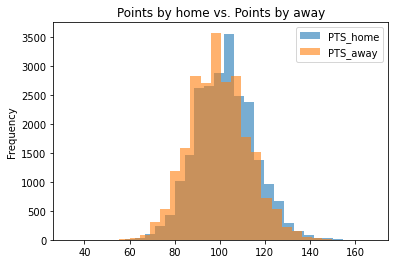

Difference:
count    23421.000000
mean         2.946843
std         13.289384
min        -58.000000
25%         -6.000000
50%          4.000000
75%         11.000000
max         61.000000
dtype: float64


In [154]:
plot_diff(games_df['PTS_home'], games_df['PTS_away'], 'Points by home vs. Points by away')

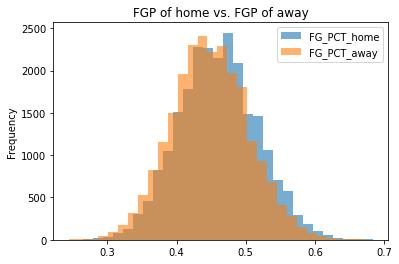

Difference:
count    23421.000000
mean         0.011578
std          0.077756
min         -0.307000
25%         -0.040000
50%          0.011000
75%          0.065000
max          0.319000
dtype: float64


In [155]:
plot_diff(games_df['FG_PCT_home'], games_df['FG_PCT_away'], 'FGP of home vs. FGP of away')

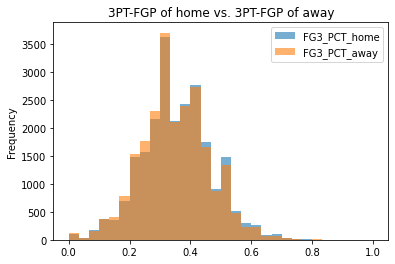

Difference:
count    23421.000000
mean         0.006705
std          0.160215
min         -0.800000
25%         -0.098000
50%          0.007000
75%          0.112000
max          0.700000
dtype: float64


In [156]:
plot_diff(games_df['FG3_PCT_home'], games_df['FG3_PCT_away'], '3PT-FGP of home vs. 3PT-FGP of away')

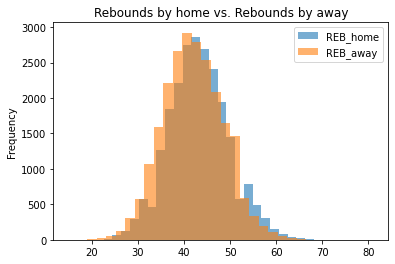

Difference:
count    23421.000000
mean         1.314504
std          8.945655
min        -39.000000
25%         -5.000000
50%          1.000000
75%          7.000000
max         38.000000
dtype: float64


In [157]:
plot_diff(games_df['REB_home'], games_df['REB_away'], 'Rebounds by home vs. Rebounds by away')

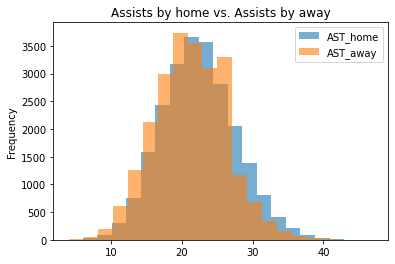

Difference:
count    23421.000000
mean         1.399385
std          6.748116
min        -24.000000
25%         -3.000000
50%          1.000000
75%          6.000000
max         26.000000
dtype: float64


In [158]:
plot_diff(games_df['AST_home'], games_df['AST_away'], 'Assists by home vs. Assists by away',bins=20)